In [350]:
import pandas as pd
import json
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
import umap
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
import umap
import hdbscan
from itertools import product
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import re
import html
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import json

# Data 

On concatene toute la data que l'on a traité pour l'instant : textes, features et images

In [351]:

photos = pd.read_csv('embeddings_by_business.csv')
texte=pd.read_csv("restaurants_embeddings_1.2.csv")
features=pd.read_csv("features.csv")
photos.rename(columns={'gbusiness_id':'business_id'}, inplace=True)
df=pd.merge(photos, features, on='business_id', how='outer')
df.rename(columns={'embedding':'image_embedding'}, inplace=True)
df=pd.merge(df, texte, on='business_id', how='outer')
df.rename(columns={'embedding':'texte_embedding'}, inplace=True)



In [352]:
data = []
with open("data/philly_restaurant_reviews.json", "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))
texte_original = pd.DataFrame(data)

# nombre d'avis par business
textes_40 = (
    texte_original
    .sort_values("date", ascending=False)   # du plus récent au plus ancien
    .groupby("business_id")
    .head(40)                                # garder les 40 plus récents
    .groupby("business_id")["text"]
    .apply(lambda x: " ".join(x))            # concatener les textes
    .reset_index()
)

In [353]:
df=pd.merge(df, textes_40, on='business_id', how='outer')

In [354]:
df

,business_id,image_embedding,n_labels,labels_present,review_count,log_review_count,stars,rating_std,positive_ratio,negative_ratio,...,review_growth_rate,expert_reviewer_ratio,elite_reviewer_ratio,high_influence_ratio,mean_influence_score,cluster_ambiance,is_open,texte_embedding,n_reviews,text
0,-0M0b-XhtFagyLmsBtOe8w,[ 9.81536725e-03 -1.35909736e-03 1.12843779e-...,1.0,inside,18,2.944439,3.722222,0.894792,0.722222,0.055556,...,0.000000,0.555556,0.0,0.500000,2.795045,2,0,[ 7.09432513e-02 -3.42724137e-02 8.07000473e-...,18,Ok so this place is an extremely odd hole in t...
1,-0PN_KFPtbnLQZEeb23XiA,NaN,NaN,NaN,11,2.484907,3.363636,1.361817,0.545455,0.181818,...,0.000000,0.272727,0.0,0.181818,1.469558,0,0,[-2.71314271e-02 5.99383237e-03 1.04649998e-...,11,Far and away the best Chinese food to order if...
2,-0TffRSXXIlBYVbb5AwfTg,[-2.06359725e-03 2.78890153e-02 9.09338878e-...,4.0,"drink, food, inside, outside",1132,7.032624,4.355124,0.983165,0.851590,0.066254,...,0.041519,0.380742,0.0,0.183746,1.486067,3,1,[-1.04763359e-02 -1.26201734e-02 5.99257536e-...,40,I went to indieblue a few years ago for happy ...
3,-0eUa8TsXFFy0FCxHYmrjg,[ 3.80490937e-02 -7.54836206e-04 8.75527248e-...,1.0,food,28,3.367296,3.964286,1.070899,0.714286,0.142857,...,0.000000,0.392857,0.0,0.107143,1.333880,0,0,[-2.71835923e-02 1.08817406e-02 8.43176693e-...,28,"We are sitting in an ICU waiting room, several..."
4,-1B9pP_CrRBJYPICE5WbRA,[-2.49907263e-02 3.30465585e-02 3.43133989e-...,2.0,"food, inside",851,6.747587,3.808461,1.205760,0.696827,0.150411,...,0.014101,0.327850,0.0,0.166863,1.406769,3,1,[-2.29447149e-02 -1.02999406e-02 8.30745846e-...,40,The food is absolutely amazing. I get food ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5847,zxY4DgtXsVHihSUpsmwamg,NaN,NaN,NaN,6,1.945910,4.333333,0.516398,1.000000,0.000000,...,0.000000,0.666667,0.0,0.500000,3.501224,0,1,[-1.96215492e-02 -2.92070061e-02 1.12719256e-...,6,This Place has Good Hoagies and the Staff is s...
5848,zy7uNOvpykrq-XlmDY_wHA,NaN,NaN,NaN,6,1.945910,3.166667,0.983192,0.500000,0.333333,...,0.000000,0.500000,0.0,0.500000,3.254321,0,0,[ 2.07472276e-02 6.47700299e-03 1.08284362e-...,6,"Sadiki's is now Relish, nothing last's over th..."
5849,zyMkbavgHASQtqVwaock9A,NaN,NaN,NaN,21,3.091042,3.809524,0.928388,0.761905,0.142857,...,0.000000,0.238095,0.0,0.238095,1.351094,0,0,[-3.72523628e-02 -1.80212533e-04 8.31776336e-...,21,I've had pretty much everything on the menu an...
5850,zz-fcqurtm77bZ_rVvo2Lw,[ 3.73759915e-02 5.26558618e-02 -2.25258733e-...,1.0,food,25,3.258097,4.480000,0.714143,0.880000,0.000000,...,0.000000,0.600000,0.0,0.440000,2.349051,6,0,[-4.03948501e-02 -2.41992772e-02 7.34254345e-...,25,"My love affair with Yumtown began with ""The Jo..."


On supprime les restaurants fermés (inutile pour nous) et on garde que ceux qui ont plus de 5 reviews

In [355]:
df = df[df['is_open'] != 0]
# On ne garde que ceux qui ont 5 reviews ou plus
df = df[df['n_reviews'] >= 5]
df = df.reset_index(drop=True)

In [356]:
df

,business_id,image_embedding,n_labels,labels_present,review_count,log_review_count,stars,rating_std,positive_ratio,negative_ratio,...,review_growth_rate,expert_reviewer_ratio,elite_reviewer_ratio,high_influence_ratio,mean_influence_score,cluster_ambiance,is_open,texte_embedding,n_reviews,text
0,-0TffRSXXIlBYVbb5AwfTg,[-2.06359725e-03 2.78890153e-02 9.09338878e-...,4.0,"drink, food, inside, outside",1132,7.032624,4.355124,0.983165,0.851590,0.066254,...,0.041519,0.380742,0.0,0.183746,1.486067,3,1,[-1.04763359e-02 -1.26201734e-02 5.99257536e-...,40,I went to indieblue a few years ago for happy ...
1,-1B9pP_CrRBJYPICE5WbRA,[-2.49907263e-02 3.30465585e-02 3.43133989e-...,2.0,"food, inside",851,6.747587,3.808461,1.205760,0.696827,0.150411,...,0.014101,0.327850,0.0,0.166863,1.406769,3,1,[-2.29447149e-02 -1.02999406e-02 8.30745846e-...,40,The food is absolutely amazing. I get food ...
2,-3ArWZfDjfab8qVHf3WVtg,NaN,NaN,NaN,5,1.791759,4.000000,1.224745,0.800000,0.200000,...,0.000000,0.200000,0.0,0.200000,1.772582,0,1,[ 5.67509746e-03 -2.48830207e-02 1.22692706e-...,5,We tried Taste Africa for dinner. The restaura...
3,-3m_nXlyvdKAVNNmVirpGQ,[ 4.18253340e-02 3.11946436e-02 7.25553887e-...,1.0,food,16,2.833213,3.500000,1.673320,0.500000,0.312500,...,0.000000,0.250000,0.0,0.062500,0.960622,0,1,[-2.88571185e-03 2.43277028e-02 4.00934890e-...,16,I wouldn't recommend. Their staff bullies othe...
4,-5Rah4ZvWsDu4oilUZxhtw,[ 1.78232579e-02 8.69476836e-03 1.89592878e-...,2.0,"inside, outside",363,5.897154,3.804408,1.131069,0.710744,0.129477,...,0.013774,0.504132,0.0,0.338843,2.260549,3,1,[ 6.31170571e-02 -3.02442070e-02 5.79875298e-...,40,I go in to the venue. World Cafe Live is a c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3520,zvvl3c1FO3O3BZdhusficA,[-9.02544490e-03 5.65394008e-03 1.48079185e-...,2.0,"food, inside",30,3.433987,3.833333,1.341212,0.733333,0.200000,...,1.000000,0.433333,0.0,0.266667,1.386318,3,1,[ 2.31991839e-02 -1.00361472e-02 5.26289418e-...,30,"Must try: birria tacos, pescado, Mariscos tost..."
3521,zwTmOj4B_OVPMTMYijQiKg,NaN,NaN,NaN,66,4.204693,3.742424,1.099799,0.681818,0.106061,...,0.000000,0.575758,0.0,0.424242,2.399986,7,1,[ 4.54111956e-02 2.98050791e-02 3.55221331e-...,40,"On a scorching summer day, this place gave us ..."
3522,zwd4dyQ5ovnjVojWfAuhMw,[-2.05638437e-02 5.98593325e-02 9.08136825e-...,2.0,"food, outside",246,5.509388,4.097561,0.976580,0.784553,0.065041,...,0.016260,0.361789,0.0,0.256098,1.807724,9,1,[-4.37345058e-02 -3.43789272e-02 2.55948305e-...,40,BBEST greasy wraps. Only say greasy bc a norma...
3523,zxRmQ_FWVowh8rlzLCSURQ,NaN,NaN,NaN,25,3.258097,3.240000,1.535144,0.560000,0.320000,...,0.000000,0.280000,0.0,0.040000,0.783046,0,1,[-3.26791406e-02 -2.39595422e-03 5.61013035e-...,25,This has become our go to spot for cheesesteak...


Code pour converdit les embedding en le nombre de dimension de base

In [357]:
import numpy as np
# Étape 1: Convertir les strings en vecteurs numériques
def convert_embeddings(embeddings_strings):
    """
    Convertit un array de strings d'embeddings en array numérique XD
    Les embeddings 'nan' sont gardés comme vecteurs de NaN
    """
    embeddings_list = []
    embedding_dim = None
    
    # Premier passage pour déterminer la dimension
    for emb_str in embeddings_strings:
        if isinstance(emb_str, np.ndarray):
            emb_str = emb_str[0]
        
        if emb_str != 'nan' and emb_str != 'None':
            try:
                emb_str_clean = emb_str.strip('[]')
                emb_array = np.fromstring(emb_str_clean, sep=' ')
                embedding_dim = len(emb_array)
                break
            except:
                continue
    
    if embedding_dim is None:
        raise ValueError("Impossible de déterminer la dimension des embeddings")
    
    print(f" Dimension des embeddings: {embedding_dim}")
    
    # Deuxième passage pour convertir tous les embeddings
    for i, emb_str in enumerate(embeddings_strings):
        # Extraire la string (elle est dans un array de shape (1,))
        if isinstance(emb_str, np.ndarray):
            emb_str = emb_str[0]
        
        # Si c'est nan, créer un vecteur de NaN
        if emb_str == 'nan' or emb_str == 'None':
            nan_vector = np.full(embedding_dim, np.nan)
            embeddings_list.append(nan_vector)
            continue
        
        try:
            # Nettoyer la string et convertir en array
            emb_str_clean = emb_str.strip('[]')
            emb_array = np.fromstring(emb_str_clean, sep=' ')
            embeddings_list.append(emb_array)
        except Exception as e:
            print(f"Erreur pour l'embedding {i}: {e} - remplacé par NaN")
            nan_vector = np.full(embedding_dim, np.nan)
            embeddings_list.append(nan_vector)
    
    # Convertir en array NumPy 2D
    embeddings_2d = np.array(embeddings_list)
    
    # Compter les NaN
    n_nan = np.isnan(embeddings_2d).any(axis=1).sum()
    print(f"✓ {n_nan} embeddings avec NaN gardés")
    
    return embeddings_2d


In [358]:
image_embedding = convert_embeddings(df['image_embedding'].tolist())
texte_embedding=convert_embeddings(df['texte_embedding'].tolist())
features = df[['log_review_count', 'stars', 'rating_std', 'positive_ratio', 
               'negative_ratio',
               'business_age_years', 'review_growth_rate', 'expert_reviewer_ratio', 
               'elite_reviewer_ratio', 'high_influence_ratio', 'mean_influence_score']]

 Dimension des embeddings: 512
Erreur pour l'embedding 2: 'float' object has no attribute 'strip' - remplacé par NaN
Erreur pour l'embedding 5: 'float' object has no attribute 'strip' - remplacé par NaN
Erreur pour l'embedding 8: 'float' object has no attribute 'strip' - remplacé par NaN
Erreur pour l'embedding 9: 'float' object has no attribute 'strip' - remplacé par NaN
Erreur pour l'embedding 11: 'float' object has no attribute 'strip' - remplacé par NaN
Erreur pour l'embedding 14: 'float' object has no attribute 'strip' - remplacé par NaN
Erreur pour l'embedding 15: 'float' object has no attribute 'strip' - remplacé par NaN
Erreur pour l'embedding 16: 'float' object has no attribute 'strip' - remplacé par NaN
Erreur pour l'embedding 22: 'float' object has no attribute 'strip' - remplacé par NaN
Erreur pour l'embedding 25: 'float' object has no attribute 'strip' - remplacé par NaN
Erreur pour l'embedding 26: 'float' object has no attribute 'strip' - remplacé par NaN
Erreur pour l'em

# Clustering

Afin de clusteriser nous avons proceder comme suit : 
- Dabord on reduit la dimensionnalité des textes qui est beaucoup trop importante et qui risque de completmeent ecraser les features numeriques. On utilise pour cela la PCA, umap etant un peu moins performante sur les grosses dimensions
- Ensuite on definit une ponderation alpha qui va donnée plus d'importance au texte ou aux features. grace a alpha on peut calculer la contribution exacte de chacun des deux en fonction de la valeur d'alpha et de la dimension des textes et des features (calcul en annexe)
- on projette ensuite le tout sur umap pour legerment diminuer deja la dimension pour hdbscan et pour 'derouler' la reductin lineaire que l'on a fait avec PCA
- Puis on clusterise avec hdbscan 

(Pour prendre l'ensemble de ces decisions nous nous sommes basés sur l'etat de l'art : "A Survey and an Empirical Evaluation of Multi-View Clustering Approaches", Zhou et al ; "BERTopic: Neural topic modeling with a class-based TF-IDF procedure", Grootendorst)

Au depart nosu avins essayé plusieurs valeurs des differents parametres mais nous avions des resultats instales donc nous avons decidé de faire une greed search sur pca_components,alpha,umap_n_components,umap_n_neighbors,min_cluster_size,min_samples,cluster_selection_method. On a definit les zones de recherche de facon logique et en testant
- Des pca pas trop faible spour garder une grande partie de la variance
- un alpha qui se rapproche de la moyenne basse pour justement ne pas donner trop de poids aux textes
- umap pas trop bas pour garder assez d'informations car on a des données tres disperses
- des min clustering standard pour la quantité de variable que l'on a 

On a ensuite definit un score a titre indicatif pour pouvoir structurer les resultats : on ajoute des points lorsque par exemple l'outliers est en dessous de la cibke, la silhouette au dessus de la cible et on penalise les clusters faible (ilhouette)

In [359]:
def grid_search(texte_embedding, features, 
                              target_outliers_pct=15,
                              min_clusters=5,
                              min_silhouette=0.25,
                              verbose=True):
    """
    Recherche par grille pour optimiser les hyperparamètres 
    """
    
    # --- DÉFINITION DE LA GRILLE D'EXPLORATION ---
    param_grid = {
        # PCA : Réduit la dimension des vecteurs de texte pour ne pas écraser les 'features'
        'pca_components': [50, 60, 70],
        
        # Alpha : Pondération entre Texte (alpha) et Stats (1-alpha)
        # 0.7 = 70% d'importance donnée au sens du texte
        'alpha': [0.3, 0.4, 0.5],
        
        # UMAP : Projection non-linéaire pour préparer le terrain au clustering
        'umap_n_components': [20, 25, 30],
        'umap_n_neighbors': [10, 15, 20],
        
        # HDBSCAN : L'algorithme de clustering lui-même
        'min_cluster_size': [30, 40, 50, 60], # Taille mini d'un groupe
        'min_samples': [20, 30, 40, 50],      # Sensibilité au bruit (plus c'est haut, plus il y a d'outliers)
        'cluster_selection_method': ['eom', 'leaf'] # eom=global, leaf=plus précis
    }
    
    # Génération de toutes les combinaisons possibles
    keys = param_grid.keys()
    values = param_grid.values()
    combinations = list(product(*values))
    
    # FILTRE : HDBSCAN impose que min_samples soit <= min_cluster_size
    valid_combinations = [
        combo for combo in combinations
        if dict(zip(keys, combo))['min_samples'] <= dict(zip(keys, combo))['min_cluster_size']
    ]
    
    n_total = len(valid_combinations)
    print(f"Testing {n_total} configurations...\n")
    
    # Initialisation des variables
    results = []
    best_score = -np.inf
    best_params = None
    best_labels = None
    best_embedded = None
    best_details = None
    
    # Barre de progression
    iterator = tqdm(valid_combinations, desc="Grid Search") if verbose else valid_combinations
    
    for combo in iterator:
        params = dict(zip(keys, combo))
        
        try:
            # 1. RÉDUCTION PCA (Texte uniquement)
            pca = PCA(n_components=params['pca_components'])
            text_reduced = pca.fit_transform(texte_embedding)
            
            # 2. NORMALISATION (Features numériques)
            # RobustScaler est moins sensible aux valeurs aberrantes que StandardScaler
            stats_scaled = RobustScaler().fit_transform(features)
            
            # 3. FUSION DES DEUX MONDES
            # On multiplie chaque matrice par son poids alpha
            alpha = params['alpha']
            combined = np.concatenate([
                alpha * text_reduced,
                (1 - alpha) * stats_scaled
            ], axis=1)
            
            # 4. PROJECTION UMAP
            # Réduit l'espace fusionné à une dimension exploitable par HDBSCAN
            reducer = umap.UMAP(
                n_components=params['umap_n_components'],
                n_neighbors=params['umap_n_neighbors'],
                min_dist=0.0,
                metric='euclidean',
                random_state=42,
                verbose=False
            )
            embedded = reducer.fit_transform(combined)
            
            # 5. CLUSTERING HDBSCAN
            clusterer = hdbscan.HDBSCAN(
                min_cluster_size=params['min_cluster_size'],
                min_samples=params['min_samples'],
                metric="euclidean",
                cluster_selection_method=params['cluster_selection_method']
            )
            labels = clusterer.fit_predict(embedded)
            
            # --- CALCUL DES MÉTRIQUES ---
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_outliers = (labels == -1).sum()
            outlier_pct = n_outliers / len(labels) * 100
            
            # On ne calcule la silhouette que sur les points qui ne sont pas du bruit (-1)
            mask_clustered = labels != -1
            
            if mask_clustered.sum() > 0 and n_clusters > 1:
                # Score de cohésion globale
                silhouette_global = silhouette_score(
                    embedded[mask_clustered], 
                    labels[mask_clustered]
                )
                
                # Scores de silhouette pour chaque point individuel
                silhouette_vals = silhouette_samples(
                    embedded[mask_clustered],
                    labels[mask_clustered]
                )
                
                labels_clustered = labels[mask_clustered]
                
                # Analyse granulaire par cluster
                cluster_details = []
                min_cluster_silhouette = 1.0
                n_bad_clusters = 0  # Clusters avec silhouette négative (mauvais)
                n_weak_clusters = 0 # Clusters peu denses
                
                for cluster_id in set(labels_clustered):
                    mask = labels_clustered == cluster_id
                    cluster_size = mask.sum()
                    cluster_silhouette = silhouette_vals[mask].mean()
                    
                    cluster_details.append({
                        'id': cluster_id,
                        'size': cluster_size,
                        'silhouette': cluster_silhouette
                    })
                    
                    # Mise à jour du pire score de cluster trouvé
                    if cluster_silhouette < min_cluster_silhouette:
                        min_cluster_silhouette = cluster_silhouette
                    
                    # Identification des clusters problématiques
                    if cluster_silhouette < 0:
                        n_bad_clusters += 1
                    elif cluster_silhouette < 0.2:
                        n_weak_clusters += 1
                
                # Vérification de l'équilibre (éviter qu'un cluster mange tout le dataset)
                sizes = [c['size'] for c in cluster_details]
                largest_cluster_pct = max(sizes) / len(labels) * 100
                
                # Indice Davies-Bouldin (plus il est bas, mieux c'est)
                db_score = davies_bouldin_score(
                    embedded[mask_clustered],
                    labels_clustered
                )
            else:
                # Valeurs par défaut si le clustering a échoué
                silhouette_global = -1
                min_cluster_silhouette = -1
                n_bad_clusters = 999
                n_weak_clusters = 999
                db_score = 999
                cluster_details = []
                largest_cluster_pct = 100
            
            # --- LOGIQUE DU SCORING ---
            # On définit des critères de succès
            meets_outliers = abs(outlier_pct - target_outliers_pct) <= 7 # Proche de la cible
            meets_clusters = n_clusters >= min_clusters                 # Assez de groupes
            meets_silhouette = silhouette_global >= min_silhouette     # Qualité minimale
            no_terrible_clusters = n_bad_clusters == 0                  # Pas de cluster "mélangé"
            reasonable_balance = largest_cluster_pct < 40               # Répartition saine
            
            if (meets_outliers and meets_clusters and meets_silhouette and 
                no_terrible_clusters and reasonable_balance):
                # Formule de score si tout va bien (On récompense la silhouette et le nb de clusters)
                score = (
                    silhouette_global * 1000 +
                    min_cluster_silhouette * 200 +
                    n_clusters * 20 +
                    (1 - outlier_pct/100) * 100 -
                    n_weak_clusters * 50 -
                    abs(outlier_pct - target_outliers_pct) * 10
                )
            else:
                # Très fortes pénalités si un critère n'est pas rempli
                score = -1000
                if not meets_outliers:
                    score -= abs(outlier_pct - target_outliers_pct) * 20
                if not meets_clusters:
                    score -= (min_clusters - n_clusters) * 100
                if not meets_silhouette:
                    score -= (min_silhouette - silhouette_global) * 500
                if n_bad_clusters > 0:
                    score -= n_bad_clusters * 300
            
            # Sauvegarde du résultat de l'itération
            result = {
                **params,
                'n_clusters': n_clusters,
                'n_outliers': n_outliers,
                'outlier_pct': outlier_pct,
                'silhouette_global': silhouette_global,
                'score': score,
                'meets_all': (score > 0)
            }
            results.append(result)
            
            # Mise à jour du "Best" si le score dépasse le précédent
            if score > best_score:
                best_score = score
                best_params = params.copy()
                best_labels = labels.copy()
                best_embedded = embedded.copy()
                best_details = cluster_details.copy()
                
                if verbose:
                    tqdm.write(f"\n✨ Nouveau meilleur: score={score:.1f} ({n_clusters} clusters)")
        
        except Exception as e:
            if verbose:
                tqdm.write(f" Erreur: {e}")
            continue
            
    # Transformation des résultats en DataFrame pour analyse facile
    results_df = pd.DataFrame(results)
    return {
        'best_params': best_params,
        'best_labels': best_labels,
        'best_embedded': best_embedded,
        'best_details': best_details,
        'results_df': results_df,
        'best_score': best_score
    }

In [360]:
#============================================================================

# UTILISATION

# ============================================================================



"""





#grid search 

results = grid_search(

texte_embedding=texte_embedding,

features=features,

target_outliers_pct=15,

min_clusters=6,

min_silhouette=0.25,

verbose=True

)



# 3. Sauvegarder

results['results_df'].to_csv('grid_search.csv', index=False)





"""

"\n\n\n\n\n\n#grid search \n\nresults = grid_search(\n\ntexte_embedding=texte_embedding,\n\nfeatures=features,\n\ntarget_outliers_pct=15,\n\nmin_clusters=6,\n\nmin_silhouette=0.25,\n\nverbose=True\n\n)\n\n\n\n# 3. Sauvegarder\n\nresults['results_df'].to_csv('grid_search.csv', index=False)\n\n\n\n\n\n"

In [361]:
results=pd.read_csv("grid_search.csv")

In [362]:
results.head(30)

,pca_components,alpha,umap_n_components,umap_n_neighbors,min_cluster_size,min_samples,cluster_selection_method,n_clusters,n_outliers,outlier_pct,silhouette_global,min_cluster_silhouette,n_bad_clusters,n_weak_clusters,largest_cluster_pct,davies_bouldin,score,meets_all
0,60,0.7,25,10,50,20,eom,14,892,25.304965,0.447034,0.254002,0,0,22.553191,0.761858,799.480174,True
1,70,0.7,25,10,60,20,eom,14,860,24.397163,0.423844,0.246723,0,0,22.695035,0.756003,784.819889,True
2,60,0.5,30,10,60,20,eom,14,935,26.524823,0.422477,0.230132,0,0,12.567376,0.758983,756.729961,True
3,50,0.7,20,10,60,20,eom,13,907,25.730496,0.418898,0.271925,0,0,22.070922,0.751977,750.247955,True
4,50,0.5,25,10,60,20,eom,13,894,25.361702,0.420448,0.223599,0,0,16.567376,0.706667,746.188543,True
5,50,0.7,30,10,60,30,eom,11,938,26.609929,0.448262,0.331368,0,0,21.702128,0.738221,741.826660,True
6,50,0.7,25,10,60,20,eom,13,922,26.156028,0.414085,0.231917,0,0,21.787234,0.785641,732.752084,True
7,50,0.7,25,10,50,30,eom,12,895,25.390071,0.420127,0.244862,0,0,21.702128,0.697074,729.808238,True
8,70,0.5,25,10,60,20,eom,13,948,26.893617,0.423836,0.201623,0,0,16.709220,0.705452,728.331141,True
9,70,0.5,30,10,60,20,eom,13,951,26.978723,0.419421,0.192535,0,1,14.382979,0.773556,671.162515,True


Pour choisir la combinaison on ene prend pas forcement la premiere sur la liste. On a decidé de dabord priviegier l'equilivre entre features et textes : avec 50 vectteurs de textes, 11 de features, 0.3 de alpha, on obtient une influence de chacun d'environ 50% donc euqilibré (calcul en annexe).
Ensuite en fonction de ca c'est la ligne 20 qui nous semble etre la meilleure en terme d'outliers, de silhouette ect apres plusieurs tests

(on ne relance pas pour eviter les petites variations)

In [363]:

# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler, RobustScaler
# import umap
# import hdbscan
# 
# # 1. Réduire les embeddings texte
# pca = PCA(n_components=50)  
# text_reduced = pca.fit_transform(texte_embedding)
# print(f"Variance conservée: {pca.explained_variance_ratio_.sum():.1%}")
# 
# # 2. Normaliser
# text_scaled = StandardScaler().fit_transform(text_reduced)
# stats_scaled = RobustScaler().fit_transform(features)  # Robuste aux outliers
# 
# # 3. Combiner avec poids ajustable
# alpha = 0.3  
# combined = np.concatenate([
#     alpha * text_scaled,
#     (1 - alpha) * stats_scaled
# ], axis=1)
# 
# # 4. UMAP pour capturer les structures non-linéaires
# reducer = umap.UMAP(
#     n_components=30,
#     n_neighbors=10,
#     min_dist=0.0,
#     metric='euclidean',
#     random_state=42
# )
# embedded = reducer.fit_transform(combined)
# 
# # 5. HDBSCAN
# clusterer = hdbscan.HDBSCAN(
#     min_cluster_size=60,
#     min_samples=30,
#     cluster_selection_epsilon=0.0
# )
# labels = clusterer.fit_predict(embedded)
# 
# # 6. Analyser
# n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise = (labels == -1).sum()
# print(f"Clusters: {n_clusters}, Bruit: {n_noise}/{len(labels)}")


on cree une focntion pour analyser nos clusters

In [364]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================================
# ANALYSE COMPLÈTE DES CLUSTERS
# ============================================================================

def analyze_clusters(labels, embedded=None, stats_scaled=None):
   
    print("=" * 70)
    print("ANALYSE DES CLUSTERS")
    print("=" * 70)
    
    # 1. Comptage de base
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    n_outliers = (labels == -1).sum()
    n_total = len(labels)
    
    print(f"\nRÉSUMÉ GÉNÉRAL:")
    print(f"  Total de points      : {n_total}")
    print(f"  Nombre de clusters   : {n_clusters}")
    print(f"  Outliers            : {n_outliers} ({n_outliers/n_total*100:.1f}%)")
    print(f"  Points clusterisés   : {n_total - n_outliers} ({(n_total-n_outliers)/n_total*100:.1f}%)")
    
    # 2. Distribution des tailles
    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    
    print(f"\n📏 TAILLE DES CLUSTERS:")
    print("-" * 70)
    print(f"{'Cluster ID':<15} {'Taille':<15} {'% du total':<15} {'Visualisation'}")
    print("-" * 70)
    
    for cluster_id in sorted(unique_labels):
        if cluster_id == -1:
            size = n_outliers
            pct = n_outliers / n_total * 100
            bar = ""
            print(f"{'Outliers':<15} {size:<15} {pct:<14.1f}% {bar}")
        else:
            size = cluster_sizes[cluster_id]
            pct = size / n_total * 100
            bar = "█" * int(pct / 2)  # Barre visuelle
            print(f"Cluster {cluster_id:<7} {size:<15} {pct:<14.1f}% {bar}")
    
    # 3. Statistiques sur les tailles
    cluster_sizes_no_noise = cluster_sizes[cluster_sizes.index != -1]
    
    print(f"\ STATISTIQUES DES TAILLES (hors outliers):")
    print(f"  Plus petit cluster   : {cluster_sizes_no_noise.min()}")
    print(f"  Plus grand cluster   : {cluster_sizes_no_noise.max()}")
    print(f"  Taille moyenne       : {cluster_sizes_no_noise.mean():.0f}")
    print(f"  Taille médiane       : {cluster_sizes_no_noise.median():.0f}")
    print(f"  Écart-type          : {cluster_sizes_no_noise.std():.0f}")
    
    # 4. Équilibre
    largest_cluster_pct = cluster_sizes_no_noise.max() / n_total * 100
    
    # Entropie de Shannon
    print(f"\nÉQUILIBRE:")
    if largest_cluster_pct > 50:
        print(f"  DÉSÉQUILIBRÉ: Le plus gros cluster contient {largest_cluster_pct:.1f}% des données")
        print(f"      → Considère augmenter min_cluster_size pour le subdiviser")
    elif largest_cluster_pct > 30:
        print(f"  MODÉRÉMENT DÉSÉQUILIBRÉ: Le plus gros cluster = {largest_cluster_pct:.1f}%")
    else:
        print(f"  ÉQUILIBRÉ: Le plus gros cluster = {largest_cluster_pct:.1f}%")
    
    # 5. Qualité 
    if embedded is not None:
        print(f"\nQUALITÉ DES CLUSTERS:")
        from sklearn.metrics import silhouette_samples, davies_bouldin_score
        
        # Silhouette par cluster
        mask_clustered = labels != -1
        if mask_clustered.sum() > 0:
            silhouette_vals = silhouette_samples(embedded[mask_clustered], 
                                                labels[mask_clustered])
            
            print(f"\n  {'Cluster':<12} {'Taille':<12} {'Silhouette':<15} {'Qualité'}")
            print("  " + "-" * 60)
            
            labels_clustered = labels[mask_clustered]
            for cluster_id in sorted(set(labels_clustered)):
                mask = labels_clustered == cluster_id
                cluster_silhouette = silhouette_vals[mask].mean()
                size = mask.sum()
                
                if cluster_silhouette > 0.5:
                    quality = "tres bine"
                elif cluster_silhouette > 0.3:
                    quality = "Bon"
                elif cluster_silhouette > 0.1:
                    quality = "Moyen"
                else:
                    quality = "Faible"
                
                print(f"  Cluster {cluster_id:<4} {size:<12} {cluster_silhouette:<14.3f} {quality}")
            
            # Silhouette globale
            mean_silhouette = silhouette_vals.mean()
            print(f"\n  Silhouette moyenne globale: {mean_silhouette:.3f}")
            
            if mean_silhouette > 0.5:
                print(f"  tres bonne séparation des clusters")
            elif mean_silhouette > 0.3:
                print(f"  bonne séparation des clusters")
            elif mean_silhouette > 0.1:
                print(f"  Séparation moyenne")
            else:
                print(f" MAUVAISE séparation - structure peu claire")
            
            # Davies-Bouldin (plus bas = mieux)
            if len(set(labels_clustered)) > 1:
                db_score = davies_bouldin_score(embedded[mask_clustered], 
                                               labels_clustered)
                print(f"  Davies-Bouldin Index: {db_score:.3f} (plus bas = mieux)")
    
    # 6. Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Distribution des tailles (barplot)
    ax1 = axes[0]
    cluster_ids = [c for c in cluster_sizes.index if c != -1]
    sizes = [cluster_sizes[c] for c in cluster_ids]
    
    bars = ax1.bar(range(len(cluster_ids)), sizes)
    ax1.set_xlabel('Cluster ID')
    ax1.set_ylabel('Nombre de points')
    ax1.set_title(f'Distribution des tailles ({n_clusters} clusters)')
    ax1.set_xticks(range(len(cluster_ids)))
    ax1.set_xticklabels(cluster_ids)
    
    # Colorer la plus grosse barre
    max_idx = sizes.index(max(sizes))
    bars[max_idx].set_color('red')
    bars[max_idx].set_alpha(0.7)
    
    # Ajouter ligne outliers
    ax1.axhline(y=n_outliers, color='black', linestyle='--', 
                label=f'Outliers ({n_outliers})', alpha=0.5)
    ax1.legend()
    
    # Pie chart
    ax2 = axes[1]
    
    # Top 5 clusters + outliers + autres
    top_5 = cluster_sizes_no_noise.nlargest(5)
    pie_data = list(top_5.values)
    pie_labels = [f'Cluster {i}' for i in top_5.index]
    
    if n_outliers > 0:
        pie_data.append(n_outliers)
        pie_labels.append('Outliers')
    
    others = n_total - sum(pie_data)
    if others > 0:
        pie_data.append(others)
        pie_labels.append(f'Autres ({n_clusters - 5} clusters)')
    
    ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Répartition des points')
    
    plt.tight_layout()
    plt.savefig('cluster_distribution.png', dpi=150, bbox_inches='tight')
    print(f"\n📊 Graphiques sauvegardés: cluster_distribution.png")
    
    return {
        'n_clusters': n_clusters,
        'n_outliers': n_outliers,
        'cluster_sizes': cluster_sizes,
        'largest_cluster_pct': largest_cluster_pct
    }



In [365]:
# --- ÉTAPE DE SAUVEGARDE ---

# Créer un DataFrame pour les composantes UMAP (
#umap_cols = [f'umap_feat_{i}' for i in range(embedded.shape[1])]
#df_umap = pd.DataFrame(embedded, columns=umap_cols, index=df.index)

# On concatène tout : texte original + labels + les 30 dimensions UMAP
#df_final = pd.concat([df, df_umap], axis=1)
#df_final['cluster_label'] = labels

#df_final.to_csv('resultats_clustering_complet.csv', index=False)


ANALYSE DES CLUSTERS

RÉSUMÉ GÉNÉRAL:
  Total de points      : 3525
  Nombre de clusters   : 9
  Outliers            : 994 (28.2%)
  Points clusterisés   : 2531 (71.8%)

📏 TAILLE DES CLUSTERS:
----------------------------------------------------------------------
Cluster ID      Taille          % du total      Visualisation
----------------------------------------------------------------------
Outliers        994             28.2          % 
Cluster 0       97              2.8           % █
Cluster 1       805             22.8          % ███████████
Cluster 2       276             7.8           % ███
Cluster 3       191             5.4           % ██
Cluster 4       77              2.2           % █
Cluster 5       73              2.1           % █
Cluster 6       133             3.8           % █
Cluster 7       556             15.8          % ███████
Cluster 8       323             9.2           % ████
\ STATISTIQUES DES TAILLES (hors outliers):
  Plus petit cluster   : 73
  Plus gra

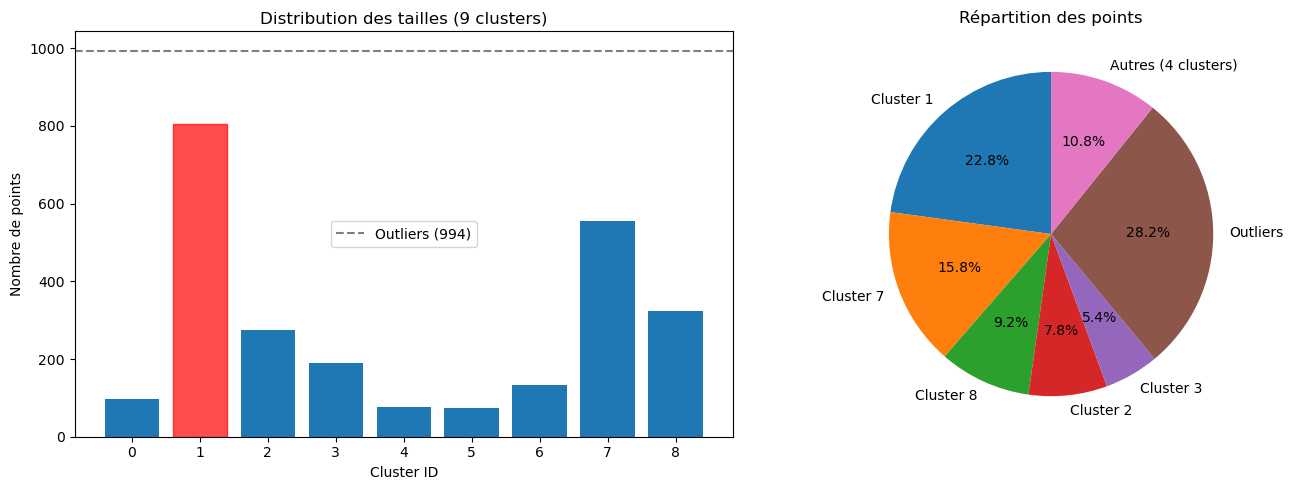

In [366]:
# --- ÉTAPE DE CHARGEMENT ---
df_load = pd.read_csv('resultats_clustering_complet.csv')

# On récupère les 30 colonnes UMAP pour la Silhouette
cols_to_use = [c for c in df_load.columns if c.startswith('umap_feat_')]
embedded_from_csv = df_load[cols_to_use].values
labels_from_csv = df_load['cluster_label'].values

# Pour stats_scaled, il vaut mieux le recalculer ou l'avoir mis dans le CSV 
# pour garantir que l'ordre des lignes est parfait.
stats = analyze_clusters(labels_from_csv, embedded=embedded_from_csv)

Avec une Silhouette moyenne de 0,528 et un Indice de Davies-Bouldin de 0,650, est statistiquement valide.
Nous avons 9 clusters ce qui est acceptable ni trop, ni pas assez pour des labels metiers.

La métrique de Silhouette (0,528) indique que les frontières entre les groupes sont claires.
Les clusters 0, 4, 5 et 6 affichent des scores supérieurs à 0,80. Géométriquement, cela signifie qu'ils forment des "îlots" de données extrêmement denses et homogènes. 
Cluster 1 : malgré sa taille importante (22,8% des données), ce cluster maintient une cohésion forte (0,526). C'est le cœur du dataset. De plus c'est le plus gros cluster mais il respecte tout de meme un equilibre.La structure est diversifiée, allant de petites niches très spécifiques (73 points) à des segments de masse (805 points).

Le taux d'outliers s'élève à 28,2% (994 points). Il est tres elevé mais nous avons choisit d'accepter cela au profit de clusters solides; nous allons plus tard tenter de reduire ces outliers

l'Indice de Davies-Bouldin : un score de 0,650, le modèle se situe dans une bonne zone (un score proche de 0 est l'idéal). Cela confirme que : Les clusters sont bien espacés les uns des autres (séparation maximale) et les points à l'intérieur de chaque cluster sont proches de leur centre (dispersion minimale).

On fait tout de meme attention à :
Analyser le contenu des Clusters 4 et 6 (Sil > 0,8). segments les plus distinctifs ; ils cachent probablement des insights très spécifiques.
Les Clusters 7 et 8 étant les plus "larges" (Sil ~0,33), ils méritent une attention particulière pour vérifier s'ils ne sont pas des regroupements par défaut.

Tenter de reduire les outliers car ils sont tres importants (on verra dans la suite)


# Interpretation des clusters

Pour interpreter les clusters nous allons les analyser un par un. On va dabord analyser les textes à l'interieur. pour cela on va dabord faire un nettoyage des textes plus important que pour le Sbert. En effet sbert comprends le sens total de la phrase, la pou c-TFIDF travailles avec des mots discrimiannt.

Puis on va egalement analyser la distributions de nos features numeriques à l'interieur des clusters

## Textes

In [367]:
df_load = pd.merge(df_load, df[['business_id', 'text', 'cluster_ambiance']], on='business_id', how='left')

In [368]:
# Liste blanche : SEULEMENT ces concepts nous intéressent
ambiance_keywords = {
    # Service
    "service", "servic", "server", "waiter", "waitress", "staff", "barista",
    "friendly", "friendli", "rude", "attentive", "attent", "helpful", "professional",
    "quick", "fast", "slow", "efficient", "prompt",
    
    # Ambiance/Atmosphère
    "atmosphere", "atmospher", "ambiance", "vibe", "mood", "feel", "feeling",
    "cozy", "romantic", "casual", "fancy", "upscale", "elegant", "modern",
    "rustic", "authentic", "traditional", "contemporary",
    
    # Environnement physique
    "clean", "dirty", "messy", "spotless", "hygiene", "hygienic",
    "decor", "decoration", "interior", "design", "lighting",
    "comfortable", "comfortabl", "uncomfortable", "cramped", "spacious", "roomy",
    "loud", "noisy", "quiet", "peaceful", "crowded", "busy", "empty",
    
    # Attente/Timing
    "wait", "waiting", "waited", "reservation", "reserv", "seat", "seated",
    "table", "tabl", "queue", "line", "delay", "delayed",
    
    # Propreté/Organisation
    "organized", "organis", "chaotic", "messy", "tidy", "neat",
    
    # Expérience client
    "welcome", "welcom", "greeting", "greet", "hospitality", "host",
    "custom", "customer", "experience", "experi", "visit", "recommend", "return",
    
    # Prix/Valeur
    "price", "priced", "pricing", "expensive", "expens", "cheap", "affordable",
    "value", "worth", "worthwhile", "overpriced", "overpric", "reasonable", "reason",
    
    # Livraison/Commande
    "delivery", "deliveri", "takeout", "pickup", "order", "ordered",
    
    # Qualité générale (à garder car distinctifs)
    "fresh", "stale", "quality", "qualiti", "portion", "size", "generous", "small"
}

porter = PorterStemmer()

def clean_for_ctfidf_whitelist(text: str) -> str:
    if not isinstance(text, str):
        return ""

    text = html.unescape(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text)

    # SEULEMENT garder les mots dans la whitelist
    tokens = [
        tok for tok in text.split()
        if tok in ambiance_keywords and len(tok) > 2
    ]

    return " ".join(tokens)

df_load["cleaned_text_ctfidf"] = df_load["text"].apply(clean_for_ctfidf_whitelist)
print(f"Nombre de mots dans la whitelist: {len(ambiance_keywords)}")
print(f"Documents avec du contenu après filtrage: {(df_load['cleaned_text_ctfidf'].str.len() > 0).sum()}/{len(df_load)}")

Nombre de mots dans la whitelist: 120
Documents avec du contenu après filtrage: 3525/3525


on fait un document avec tous les textes par cluster

In [369]:
dt = df_load.copy()

docs_per_cluster = (
    dt[dt["cluster_label"] != -1]
    .groupby("cluster_label")["cleaned_text_ctfidf"]
    .apply(" ".join)
)


In [370]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# vectorisation
vectorizer = CountVectorizer(
    min_df=5,                    # Ignore mots dans <5 restaurants
   
    ngram_range=(1, 2),          # Unigrammes + bigrammes
    token_pattern=r'\b[a-z]{3,}\b'  # Minimum 3 lettres
)


X = vectorizer.fit_transform(docs_per_cluster.values)

# c-TF-IDF
tf = X.toarray()
tf_sum = tf.sum(axis=0)

A = tf.sum(axis=1).mean()

ctfidf = tf * np.log(1 + A / tf_sum)
terms = vectorizer.get_feature_names_out()

top_words = {}

for i, cluster_id in enumerate(docs_per_cluster.index):
    scores = ctfidf[i]
    top_idx = scores.argsort()[::-1][:10]
    top_words[cluster_id] = [(terms[j], scores[j]) for j in top_idx]
for cluster_id, words in top_words.items():
    print(f"\n🟦 Cluster {cluster_id}")
    for word, score in words:
        print(f"  {word:<25} {score:.3f}")



🟦 Cluster 0
  fresh                     1919.021
  ordered                   1373.803
  quality                   1222.160
  order                     1156.952
  service                   1151.263
  recommend                 1085.545
  price                     1021.941
  experience                869.290
  delivery                  831.013
  takeout                   815.428

🟦 Cluster 1
  order                     11841.604
  ordered                   8383.855
  delivery                  7972.051
  order order               6675.068
  service                   5713.678
  customer                  5652.395
  customer service          4459.902
  ordered order             4123.554
  order ordered             3971.963
  rude                      3650.103

🟦 Cluster 2
  order                     3159.733
  ordered                   2982.667
  delivery                  2732.963
  service                   2197.183
  takeout                   1843.865
  recommend                 1811.993
 

- Cluster 0 : Qualité & Recommandations positives
(fresh, quality, recommend, price, experience) - Avis généralement positifs mettant l'accent sur la fraîcheur et le rapport qualité-prix
- Cluster 1 : Problèmes de commande & service client
(order order, customer service, rude) - le fait que rude apparait avec des elements de service (order, customer service ect) fait penser que il y'a un probleme de service client 
- Cluster 2 : Livraison & Authenticité
(delivery, takeout, authentic, fast) - Avis sur les services de livraison/emporter avec mention de l'authenticité
- Cluster 3 : Personnel & Petits établissements
(staff, friendly, wait, small) - Expériences dans de petits restaurants avec focus sur le personnel
- Cluster 4 : Expérience restaurant avec service à table
(table, reservation, server, waiter) - Avis sur l'expérience de restauration sur place avec service
- Cluster 5 : Cafés & Ambiance conviviale
(barista, friendly staff, atmosphere, line) - Avis sur des cafés avec personnel chaleureux
- Cluster 6 : Cuisine authentique & Attente
(authentic, fresh, worth, wait) - Restaurants authentiques où l'attente en vaut la peine
- Cluster 7 : Grande expérience dining
(experience, atmosphere, server) - Avis détaillés sur des expériences gastronomiques complètes
- Cluster 8 : Service rapide & efficace
(quick, fast, friendly staff) - Établissements appréciés pour leur rapidité et leur convivialité, type fast food

## Features numerique

In [371]:
df_load.columns

Index(['business_id', 'image_embedding', 'n_labels', 'labels_present',
       'review_count', 'log_review_count', 'stars', 'rating_std',
       'positive_ratio', 'negative_ratio', 'photo_count', 'log_photo_count',
       'business_age_years', 'review_growth_rate', 'expert_reviewer_ratio',
       'elite_reviewer_ratio', 'high_influence_ratio', 'mean_influence_score',
       'is_open', 'texte_embedding', 'n_reviews', 'umap_feat_0', 'umap_feat_1',
       'umap_feat_2', 'umap_feat_3', 'umap_feat_4', 'umap_feat_5',
       'umap_feat_6', 'umap_feat_7', 'umap_feat_8', 'umap_feat_9',
       'umap_feat_10', 'umap_feat_11', 'umap_feat_12', 'umap_feat_13',
       'umap_feat_14', 'umap_feat_15', 'umap_feat_16', 'umap_feat_17',
       'umap_feat_18', 'umap_feat_19', 'umap_feat_20', 'umap_feat_21',
       'umap_feat_22', 'umap_feat_23', 'umap_feat_24', 'umap_feat_25',
       'umap_feat_26', 'umap_feat_27', 'umap_feat_28', 'umap_feat_29',
       'cluster_label', 'text', 'cluster_ambiance', 'cleaned_t

In [372]:
import numpy as np

# Variables à analyser (sans image_embedding qui est une liste)
stats_vars = [
    'n_labels', 'review_count', 'log_review_count', 'stars', 'rating_std',
    'positive_ratio', 'negative_ratio', 'photo_count', 'log_photo_count',
    'business_age_years', 'review_growth_rate', 'expert_reviewer_ratio',
    'elite_reviewer_ratio', 'high_influence_ratio', 'mean_influence_score'
]

# Pour chaque cluster
for cluster_id in sorted(df_load['cluster_label'].unique()):
    if cluster_id == -1:  # Skip outliers si présents
        continue
    
    print(f"\n{'='*80}")
    print(f"🟦 CLUSTER {cluster_id}")
    print(f"{'='*80}")
    
    # Filtrer les données du cluster
    cluster_data = df_load[df_load['cluster_label'] == cluster_id]
    print(f"Nombre de restaurants: {len(cluster_data)}")
    
    # Statistiques descriptives
    stats = cluster_data[stats_vars].describe().T
    
    # Ajouter la médiane
    stats['median'] = cluster_data[stats_vars].median()
    
    # Réorganiser les colonnes
    stats = stats[['count', 'mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max']]
    
    print("\n" + stats.to_string())


# Comparaison entre clusters
print(f"\n{'='*80}")
print("📊 COMPARAISON ENTRE CLUSTERS")
print(f"{'='*80}\n")

comparison = df_load.groupby('cluster_label')[stats_vars].agg(['mean', 'median'])
print(comparison.to_string())


🟦 CLUSTER 0
Nombre de restaurants: 97

                       count        mean      median         std       min        25%         50%         75%          max
n_labels                82.0    2.134146    2.000000    1.003232  1.000000   1.000000    2.000000    3.000000     5.000000
review_count            97.0  232.659794  142.000000  317.952069  6.000000  51.000000  142.000000  234.000000  1943.000000
log_review_count        97.0    4.801124    4.962845    1.205041  1.945910   3.951244    4.962845    5.459586     7.572503
stars                   97.0    4.024464    4.056075    0.398276  3.100000   3.740426    4.056075    4.301965     4.762821
rating_std              97.0    1.161764    1.174079    0.228165  0.547723   1.015249    1.174079    1.295308     1.722478
positive_ratio          97.0    0.745589    0.762887    0.127436  0.350000   0.653061    0.762887    0.837992     1.000000
negative_ratio          97.0    0.142842    0.129204    0.085609  0.000000   0.076923    0.129204  

++ analyser les cluster ambiance!!!!!!!!!!!

## Reduction d'outliers 

j'ai direct demandé a claude d'appliquer la methode de bertopic de reduction d'outlier. A relire absolument et verifier :https://maartengr.github.io/BERTopic/getting_started/outlier_reduction/outlier_reduction.html

In [373]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

print("🔍 Réduction d'outliers + c-TF-IDF avec whitelist")
print("="*80)


# ============================================================================
# ÉTAPE 0: Filtrage avec whitelist
# ============================================================================
print("\n📝 ÉTAPE 0: Filtrage des textes avec whitelist")
print("="*80)

def filter_with_whitelist(text: str, keywords: set) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    tokens = text.split()
    filtered = [tok for tok in tokens if tok in keywords]
    return " ".join(filtered)

# Récupérer les données
topics = df_load['cluster_label'].values
texts_original = df_load["text"].tolist()

# Filtrer les textes
texts = [filter_with_whitelist(text, ambiance_keywords) for text in texts_original]

# Statistiques
non_empty = sum(1 for t in texts if len(t) > 0)
print(f"   Documents avec contenu après filtrage: {non_empty}/{len(texts)} ({non_empty/len(texts):.1%})")

n_outliers_initial = (topics == -1).sum()
n_total = len(topics)
print(f"\n📊 État initial:")
print(f"   Total documents: {n_total}")
print(f"   Outliers: {n_outliers_initial} ({n_outliers_initial/n_total:.1%})")
print(f"   Clusters valides: {len(set(topics)) - (1 if -1 in topics else 0)}")

# ============================================================================
# ÉTAPE 1: Créer les documents par cluster
# ============================================================================
print(f"\n{'='*80}")
print("ÉTAPE 1: Agrégation des textes par cluster")
print("="*80)

cluster_ids = sorted([c for c in set(topics) if c != -1])
docs_per_cluster = {}

for cluster_id in cluster_ids:
    cluster_texts = [texts[i] for i in range(len(texts)) 
                     if topics[i] == cluster_id and len(texts[i]) > 0]
    if cluster_texts:
        docs_per_cluster[cluster_id] = " ".join(cluster_texts)

docs_per_cluster = pd.Series(docs_per_cluster)
print(f"   Clusters: {len(docs_per_cluster)}")

# ============================================================================
# ÉTAPE 2: Vectorisation et c-TF-IDF
# ============================================================================
print(f"\n{'='*80}")
print("ÉTAPE 2: Calcul c-TF-IDF")
print("="*80)

vectorizer = CountVectorizer(
    min_df=2,  # Plus permissif car vocabulaire réduit
    ngram_range=(1, 2),
    token_pattern=r'\b[a-z]{3,}\b'
)

X = vectorizer.fit_transform(docs_per_cluster.values)

# c-TF-IDF
tf = X.toarray()
tf_sum = tf.sum(axis=0)
A = tf.sum(axis=1).mean()
ctfidf = tf * np.log(1 + A / tf_sum)
terms = vectorizer.get_feature_names_out()

print(f"   Vocabulaire: {len(terms)} termes")

# Top words initiaux
top_words_initial = {}
for i, cluster_id in enumerate(docs_per_cluster.index):
    scores = ctfidf[i]
    top_idx = scores.argsort()[::-1][:15]
    top_words_initial[cluster_id] = [(terms[j], scores[j]) for j in top_idx]

print("\n📝 TOP WORDS INITIAUX (avant réduction outliers):")
for cluster_id, words in top_words_initial.items():
    print(f"\n🟦 Cluster {cluster_id}")
    for word, score in words:
        print(f"  {word:<25} {score:.3f}")

# ============================================================================
# ÉTAPE 3: Réduction des outliers
# ============================================================================
print(f"\n{'='*80}")
print("ÉTAPE 3: Réduction des outliers")
print("="*80)

outlier_indices = np.where(topics == -1)[0]
print(f"   Outliers à traiter: {len(outlier_indices)}")

if len(outlier_indices) > 0:
    # Vectoriser les outliers (filtrés)
    outlier_texts = [texts[i] for i in outlier_indices if len(texts[i]) > 0]
    outlier_indices_valid = [i for i in outlier_indices if len(texts[i]) > 0]
    
    if len(outlier_texts) > 0:
        X_outliers = vectorizer.transform(outlier_texts)
        
        # c-TF-IDF pour outliers
        tf_outliers = X_outliers.toarray()
        ctfidf_outliers = tf_outliers * np.log(1 + A / tf_sum)
        
        # Similarité cosinus
        similarities = cosine_similarity(ctfidf_outliers, ctfidf)
        
        # Tester thresholds
        print("\n🔬 Test de différents thresholds:")
        threshold_results = {}
        
        for threshold in [0.05, 0.10, 0.15, 0.20, 0.25]:
            new_topics_test = topics.copy()
            reassigned_count = 0
            
            for idx, outlier_idx in enumerate(outlier_indices_valid):
                max_similarity = similarities[idx].max()
                
                if max_similarity >= threshold:
                    best_cluster_idx = similarities[idx].argmax()
                    best_cluster_id = docs_per_cluster.index[best_cluster_idx]
                    new_topics_test[outlier_idx] = best_cluster_id
                    reassigned_count += 1
            
            n_outliers_remaining = (new_topics_test == -1).sum()
            threshold_results[threshold] = (new_topics_test, reassigned_count, n_outliers_remaining)
            
            print(f"   Threshold {threshold:.2f}: {n_outliers_remaining:4d} outliers ({n_outliers_remaining/n_total:5.1%}) - réassignés: {reassigned_count:4d}")
        
        # Appliquer threshold optimal
        optimal_threshold = 0.25
        new_topics, n_reassigned, n_outliers_final = threshold_results[optimal_threshold]
        
        print(f"\n✅ Threshold optimal: {optimal_threshold}")
        print(f"   Outliers réduits: {n_outliers_initial - n_outliers_final} ({(n_outliers_initial - n_outliers_final)/n_outliers_initial:.1%})")
        
        # Mise à jour
        df_load['cluster_label_original'] = topics
        df_load['cluster_label'] = new_topics
        
        # ====================================================================
        # ÉTAPE 4: Recalcul c-TF-IDF
        # ====================================================================
        print(f"\n{'='*80}")
        print("ÉTAPE 4: Recalcul c-TF-IDF (après réduction)")
        print("="*80)
        
        docs_per_cluster_new = {}
        for cluster_id in cluster_ids:
            cluster_texts_new = [texts[i] for i in range(len(texts)) 
                                if new_topics[i] == cluster_id and len(texts[i]) > 0]
            if cluster_texts_new:
                docs_per_cluster_new[cluster_id] = " ".join(cluster_texts_new)
        
        docs_per_cluster_new = pd.Series(docs_per_cluster_new)
        
        X_new = vectorizer.transform(docs_per_cluster_new.values)
        tf_new = X_new.toarray()
        tf_sum_new = tf_new.sum(axis=0)
        A_new = tf_new.sum(axis=1).mean()
        ctfidf_new = tf_new * np.log(1 + A_new / tf_sum_new)
        
        # Top words finaux
        top_words_new = {}
        for i, cluster_id in enumerate(docs_per_cluster_new.index):
            scores = ctfidf_new[i]
            top_idx = scores.argsort()[::-1][:15]
            
            n_docs_total = (new_topics == cluster_id).sum()
            n_docs_new = ((topics == -1) & (new_topics == cluster_id)).sum()
            
            top_words_new[cluster_id] = {
                'words': [(terms[j], scores[j]) for j in top_idx],
                'n_docs': n_docs_total,
                'n_new': n_docs_new
            }
        
        print("\n📝 TOP WORDS FINAUX (après réduction):")
        for cluster_id, data in top_words_new.items():
            print(f"\n🟦 Cluster {cluster_id} ({data['n_docs']} docs, +{data['n_new']} nouveaux)")
            for word, score in data['words']:
                print(f"  {word:<25} {score:.3f}")
        
        # Répartition
        if n_reassigned > 0:
            print(f"\n{'='*80}")
            print(f"📍 Répartition des {n_reassigned} outliers réassignés:")
            print("="*80)
            
            reassigned_mask = (topics == -1) & (new_topics != -1)
            reassigned = pd.Series(new_topics[reassigned_mask])
            reassignment_counts = reassigned.value_counts().sort_index()
            
            for cluster_id, count in reassignment_counts.items():
                pct = count / n_reassigned * 100
                print(f"   → Cluster {cluster_id}: {count:3d} documents ({pct:5.1f}%)")
    else:
        print("   Aucun outlier avec contenu filtré!")
else:
    print("   Aucun outlier!")

print("\n✅ Terminé!")

🔍 Réduction d'outliers + c-TF-IDF avec whitelist

📝 ÉTAPE 0: Filtrage des textes avec whitelist
   Documents avec contenu après filtrage: 3525/3525 (100.0%)

📊 État initial:
   Total documents: 3525
   Outliers: 994 (28.2%)
   Clusters valides: 9

ÉTAPE 1: Agrégation des textes par cluster
   Clusters: 9

ÉTAPE 2: Calcul c-TF-IDF
   Vocabulaire: 5445 termes

📝 TOP WORDS INITIAUX (avant réduction outliers):

🟦 Cluster 0
  fresh                     1300.114
  ordered                   1180.557
  order                     954.766
  quality                   950.629
  service                   879.227
  recommend                 861.777
  price                     698.917
  staff                     651.389
  delivery                  637.296
  small                     596.214
  worth                     592.846
  experience                573.712
  takeout                   573.109
  wait                      529.782
  quick                     502.143

🟦 Cluster 1
  order               